In [1]:
from datetime import datetime, timedelta, date
import pandas as pd
from constants import *
from download import query_phe as query, download_phe as download, find_latest, is_msoa_data_ready
from msoa_composite import check_path
from phe import plot_summary, read_csv, load_population, vaccination_dashboard
import requests

In [3]:
release=None

In [4]:
overview_data = query(
    filters={area_type: overview},
    structure=[release_timestamp, date_col, area_name, area_code,
               new_cases_by_specimen_date, new_admissions, new_deaths_by_death_date,
               new_virus_tests]
)
overview_data

,releaseTimestamp,date,areaName,areaCode,newCasesBySpecimenDate,newAdmissions,newDeaths28DaysByDeathDate,newVirusTests
0,2021-01-15,2021-01-14,United Kingdom,K02000001,5507,NaN,316.0,695148.0
1,2021-01-15,2021-01-13,United Kingdom,K02000001,34295,NaN,741.0,628556.0
2,2021-01-15,2021-01-12,United Kingdom,K02000001,45650,NaN,918.0,584760.0
3,2021-01-15,2021-01-11,United Kingdom,K02000001,55242,4262.0,998.0,536947.0
4,2021-01-15,2021-01-10,United Kingdom,K02000001,35972,3894.0,905.0,485874.0
...,...,...,...,...,...,...,...,...
346,2021-01-15,2020-02-03,United Kingdom,K02000001,0,NaN,NaN,NaN
347,2021-01-15,2020-02-02,United Kingdom,K02000001,0,NaN,NaN,NaN
348,2021-01-15,2020-02-01,United Kingdom,K02000001,1,NaN,NaN,NaN
349,2021-01-15,2020-01-31,United Kingdom,K02000001,1,NaN,NaN,NaN


In [6]:
download('england', 'nation', new_admissions_sum, new_cases_sum, new_deaths_sum, unique_people_tested_sum, area_name='England', release=release)

PosixPath('/Users/chris/coronavirus/data/england_2021-01-15.csv')

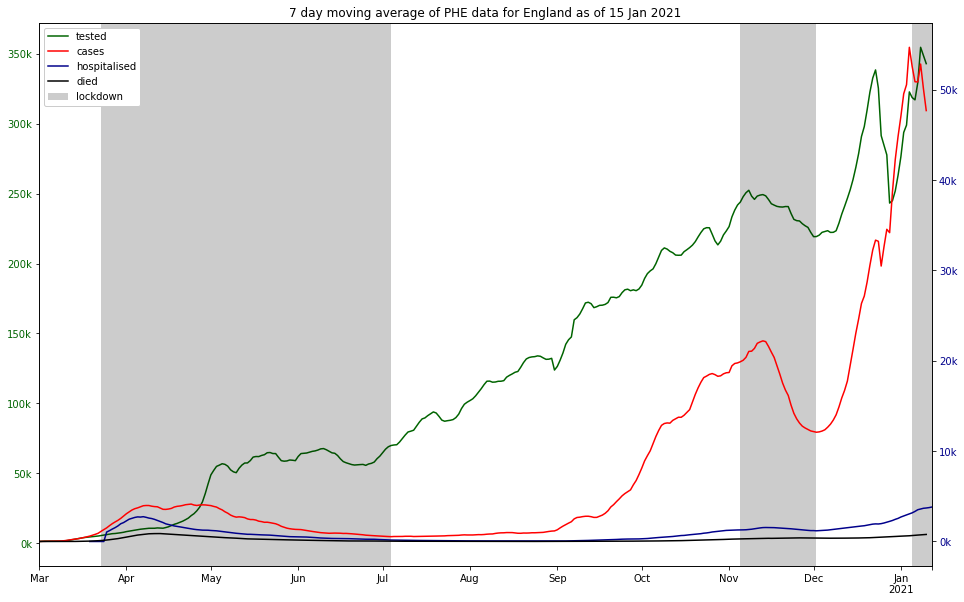

In [7]:
plot_summary(earliest_date='2020-03-01', tested_formatter=lambda y, pos: f"{y / 1_000:,.0f}k")

In [21]:
download('vaccination', 'nation', *vaccination_new_and_weekly, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_2021-01-14.csv')

In [22]:
download('vaccination_cum', 'nation', *vaccination_cumulative, release=release)

PosixPath('/Users/chris/coronavirus/data/vaccination_cum_2021-01-14.csv')

,areaName,areaCode,full,any,partial,population,full_pct,partial_pct,none_pct
0,Northern Ireland,N92000002,19010.0,102701.0,83691.0,1893667,1.003872,4.419520,94.576607
1,Scotland,S92000003,3190.0,208207.0,205017.0,5463300,0.058390,3.752622,96.188988
2,Wales,W92000004,121.0,112973.0,112852.0,3152879,0.003838,3.579332,96.416830
3,England,E92000001,415656.0,2494371.0,2078715.0,56286961,0.738459,3.693067,95.568475


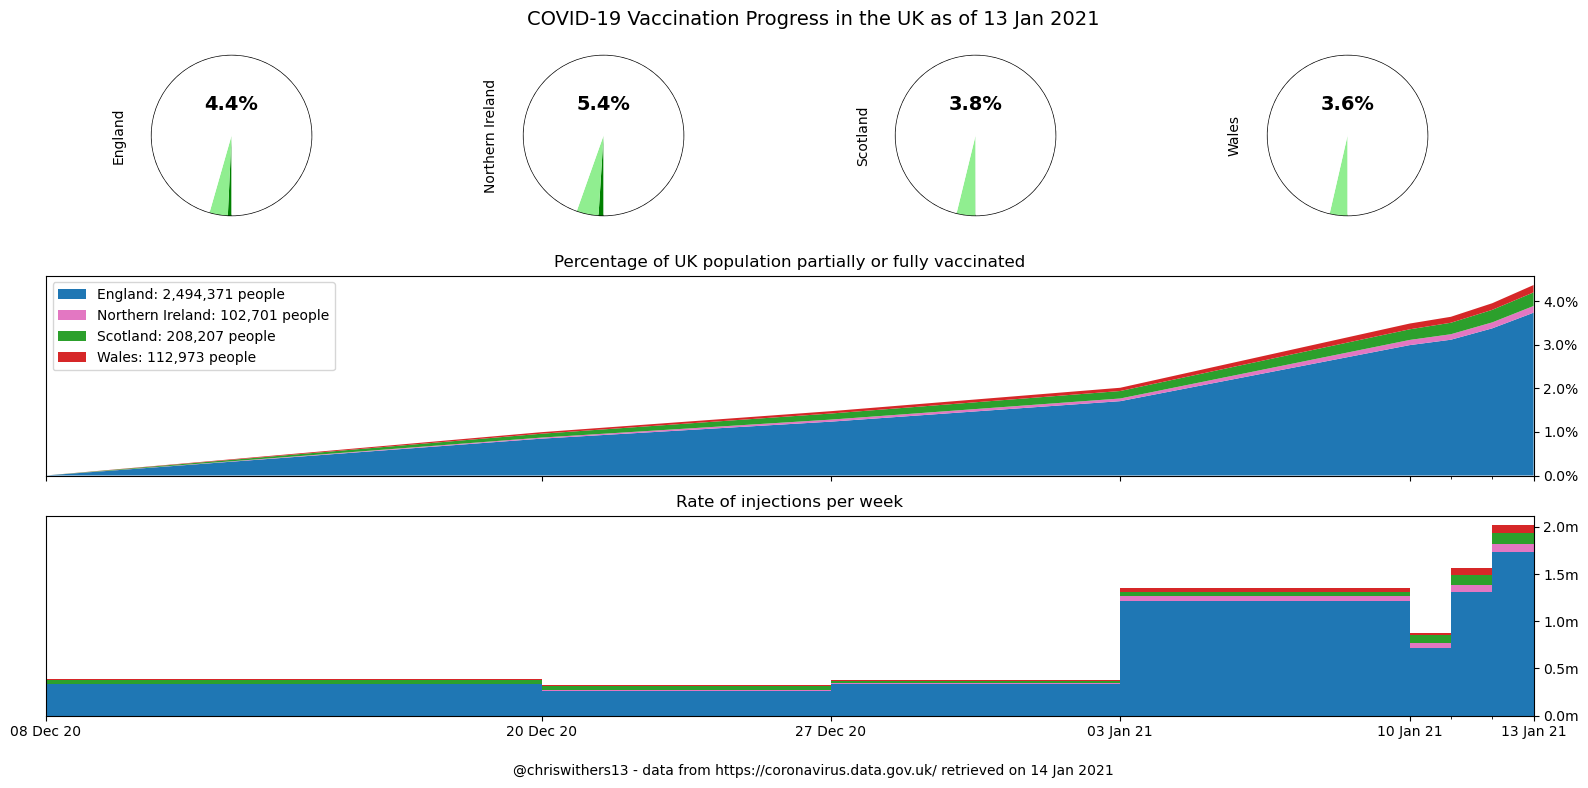

In [2]:
vaccination_dashboard()

In [24]:
download(nation, nation, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/nation_2021-01-14.csv')

In [25]:
download(region, region, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/region_2021-01-14.csv')

In [26]:
download(ltla, ltla, *standard_metrics, release=release)

PosixPath('/Users/chris/coronavirus/data/ltla_2021-01-14.csv')

In [27]:
if is_msoa_data_ready():
    path = download(msoa, msoa, new_cases_sum, new_cases_rate, new_cases_change, 'release', release=release)
    display(path)
    check_path(path)

today: 2021-01-14, release: 2021-01-14 22:40:03.450906+00:00, msoa: 2021-01-14 22:58:45+00:00


PosixPath('/Users/chris/coronavirus/data/msoa_2021-01-14.csv')